

```
# This is formatted as code
```

**Module 1: What is Human-Centered Data Science?** The provided code notebook presents an example of training a logistic regression model on a biased dataset.<br>
We provide the code to create:
1) A synthetic data set
2) Visualizations examining the data
3) A logistic regression model
4) Post-hoc analysis.<br>

The purpose of the code notebook is to provide students with a hands-on example of a human-centered data science problem and potential biases.

This code book is used to help students:<br>
* Identify who the “humans” are across a data-science lifecycle.<br>
* Reflect on assumptions about neutrality, objectivity, and measurement.<br>
* Connect HCDS to ethical, societal, and policy considerations.<br>

The code can be adapted as instructors see fit, including lengthening the example, creating more/different features, increasing the complexity of the model, and/or using your own dataset.

In [25]:
# Requirements: numpy, pandas, matplotlib, seaborn, scikit-learn
# Tested with Python 3.12, scikit-learn >= 1.0

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [26]:
# Use random seed to ensure replicability
np.random.seed(42)
n = 400

# Generate the datasest

# create gender data
# This is a simplified binary group variable
#(real systems should not treat gender this way)
# gender imbalance (60% male)
gender = np.random.choice(["male", "female"], size=n, p=[0.6, 0.4])

# age data creation
age = np.where(
    gender == "male",
    np.random.normal(35, 7, size=n),
    np.random.normal(40, 7, size=n)
)

# scores differ by gender (important for disparate impact)
score = np.where(
    gender == "male",
    np.random.normal(0.7, 0.15, size=n),   # males higher on avg
    np.random.normal(0.5, 0.15, size=n)
)

# create biased labels

# Threshold intentionally favors men (creates true imbalance)
# produces different error rates by gender.

threshold = 0.6
y = (score > threshold).astype(int)    # "Positive" label = 1 ~ 60% male

df = pd.DataFrame({
    "gender": gender,
    "age": age,
    "score": score,
    "outcome": y
})

# Encode gender for model
df["gender_male"] = (df["gender"] == "male").astype(int)


 **Prompt:** "For the dataset created here, imagine score represents a risk score used to decide whether to investigate a case. Label outcome = 1 means ‘investigate’."

**Ask:** “What assumptions are we making about gender and risk when we generate the data this way?”

In [27]:
# view a snapshot of the data set
df.head()

,gender,age,score,outcome,gender_male
0,male,44.138352,0.722563,1,1
1,female,47.723113,0.481738,0,0
2,female,40.799594,0.727017,1,0
3,male,32.828133,0.691357,1,1
4,male,37.269164,0.730165,1,1


**Explore:** When looking at a new data set it is important to explore the data. First we can look at a few of the rows of data as we do above. This tells us a bit about the values in our dataset. We can also explore the data visually through graphs.

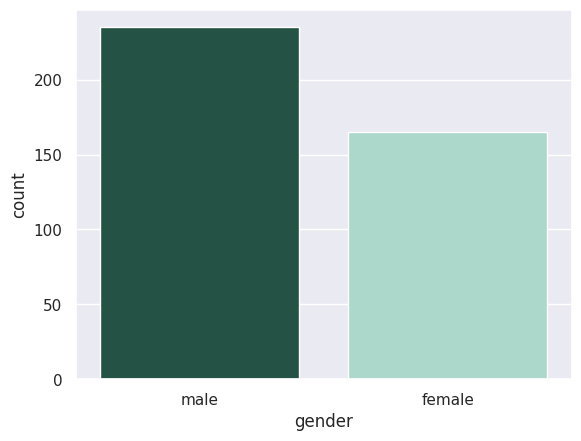

In [28]:
# visualize the count of gender in the data set

# create a custom pallete using hex codes
custom_palette = ['#1c5b49', '#a4dfce']

# create barchart of gender counts
sns.set()
sns.countplot(x='gender', hue='gender', data =df, palette = custom_palette)
plt.show()

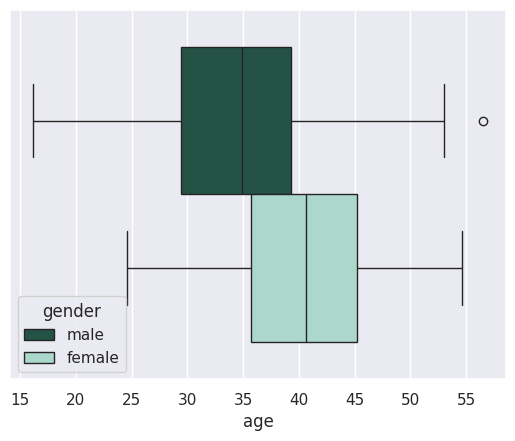

In [29]:
# visualize the distribution of age across gender
sns.set()
sns.boxplot(x='age', hue='gender', data=df, palette = custom_palette)
plt.show()

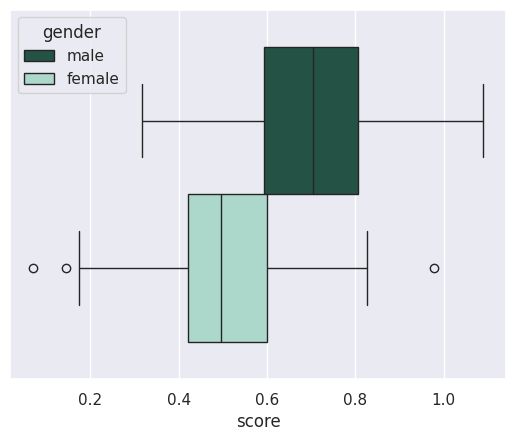

In [30]:
# visualize the distribution of scores across gender
sns.set()
sns.boxplot(x='score', hue='gender', data=df, palette = custom_palette)
plt.show()

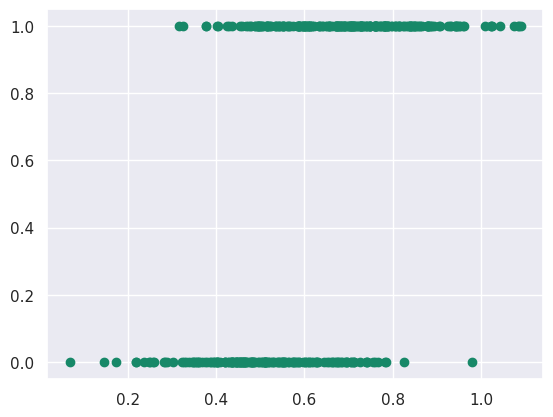

In [31]:
# plotting the binary gender scores to see the distribution
sns.set()
plt.scatter(x="score", y="gender_male", data=df, color="#178868")
plt.show()

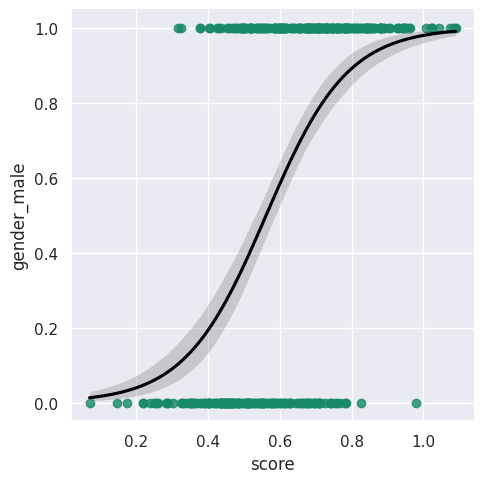

In [32]:
# plotting a logistic regression to see if score and gender have a predictive relationship
sns.set()
sns.lmplot(
x='score',
y='gender_male',
data=df,
logistic=True,
scatter_kws={"color": "#178868"},
line_kws={"color": "black"},
ci=95)
plt.show()

**Prompt:** “What patterns do you see in the distributions by gender? How might this affect decisions based on the score?”

In [33]:
# Fit logistic regression

X = df[["age", "score", "gender_male"]]
model = LogisticRegression().fit(X, y)
df["pred"] = model.predict(X)

In [34]:
# Show Overall Accuracy

overall_accuracy = (df["pred"] == df["outcome"]).mean()
print("Overall Accuracy:", round(overall_accuracy, 3))

Overall Accuracy: 0.91


**Prompt:** “Is 91% accuracy ‘good enough’? Why might that answer change once we look at groups separately?”

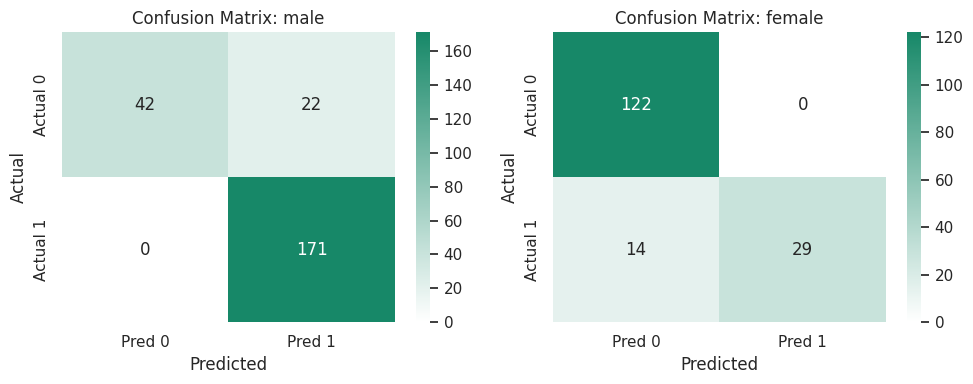

In [35]:
# Confusion Matrices by Group

# Create custom color mapping
custom_cmap = LinearSegmentedColormap.from_list(
    "white_to_green",
    ["#ffffff", "#178868"]
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, g in zip(axes, ["male", "female"]):
    subset = df[df["gender"] == g]
    cm = confusion_matrix(subset["outcome"], subset["pred"], labels=[0,1])
    sns.heatmap(cm, annot=True, fmt="d", cmap=custom_cmap, ax=ax,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["Actual 0", "Actual 1"])
    ax.set_title(f"Confusion Matrix: {g}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

**Prompt:** “Compare the error patterns for each gender. If label 1 = ‘good outcome’ vs ‘bad outcome’, who is advantaged and who is harmed?”

In [36]:
# Calculate error Rates by Group
error_rates = (
    (df["pred"] != df["outcome"])
    .groupby(df["gender"])
    .mean()
    .round(3)
)
# print error rates by gender
print("\nError rates by gender:")
print("female:", error_rates.loc["female"])
print("male:", error_rates.loc["male"])

#print coefficients
print("\nCoefficients by variable:") #print title
feature_names = ["age", "score", "gender"] #create a list of variables

# loop to print all coefficients and their varibale name
for name, coef in zip(feature_names, model.coef_[0]):
    print(f"{name}: {coef:.3f}")


#print intercept
print("\nIntercept:", round(model.intercept_[0], 3))


Error rates by gender:
female: 0.085
male: 0.094

Coefficients by variable:
age: -0.017
score: 8.415
gender: 0.820

Intercept: -4.885


**Prompt:**"What does it mean for the gender co-efficient to be positive after we control for the score?"

**Explore Further:**

1. Change the threshold value (e.g., 0.5, 0.7) and rerun the model. How do overall accuracy and group error rates change?

2. Retrain the logistic regression without the gender_male feature. Does that reduce or increase disparities in errors? Does it change overall accuracy?

3. Try changing how the score is generated for each group (for example, making the groups more similar). How does that affect fairness?

**Connecting back to Human Centered Data Science:**

This dataset and activity helps us to understand fundamental ideas in Human Centered Data Science. Specifically:

**Ethical responsibility:** Who is responsible for the way we generated data and chose model features (including gender)?

**Looking in the right places:** What information is missing from this toy dataset that you would want in a real system? Whose experiences are invisible here?

**Collective practice:** Who should be in the room when you are deciding how to generate data, choose a threshold, or select features?

**Communication:** How would you explain these results — including the different error patterns — to a non-technical stakeholder?

**Action:** What concrete changes could you make (to the data, model, or decision rule) to reduce harm to one of the groups?